In [1]:
import sys

sys.path.insert(0, '../../PSC')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from PSC.data import random_point, stiefel_point_cloud
from PSC.initialization import tube_det, tube_rank, ransac
from PSC.projections import PCA, manopt_alpha

In [4]:
N = 1000
n = 100
k = 5

s = 1000

p_true = 0.98

inlier = stiefel_point_cloud(N,n,k,int(s*p_true),0.02)
outlier = stiefel_point_cloud(N,n,k,s-int(s*p_true),0.01)

ys = np.concatenate((outlier['points'], inlier['points']))

In [5]:
ys_new = ransac(ys, n, p_true, verbose=True)
print(len(ys_new))

18 [ 3 12 10  4  6  8 19  9  2 11 14  1 18 16  0 13  7 15]
2 [ 5 17]
1 [686]
0 []
979


In [6]:
%timeit ransac(ys, n, p_true)

11.7 s ± 2.01 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Test removing points that don't meet the rank condition

In [7]:
s = [10, 50, 100, 500, 1000]
N = [10, 50, 100, 500, 1000]

In [8]:
t1 = np.zeros((len(s), len(N), 5))
t2 = np.zeros_like(t1)
t3 = np.zeros((len(s), len(N), 3))

for i, s_i in enumerate(s):
    for j, N_j in enumerate(N):
        n = int(0.2*N_j)
        k = int(0.1*N_j)

        alpha_init = random_point(N_j, n)
        
        ys = stiefel_point_cloud(N_j,n,k,s_i,0.01, alpha=alpha_init)['points']
        print(ys.shape)
        
        alpha = PCA(ys, n)

        res = %timeit -o -r 5 tube_det(ys, alpha)
        t1[i, j, :] = res.timings

        res = %timeit -o -r 5 tube_rank(ys, alpha)
        t2[i, j, :] = res.timings

        res = %timeit -o -r 3 manopt_alpha(ys, alpha, verbosity=0)
        t3[i, j, :] = res.timings

(10, 10, 1)
8.9 μs ± 20.8 ns per loop (mean ± std. dev. of 5 runs, 100,000 loops each)
12.9 μs ± 109 ns per loop (mean ± std. dev. of 5 runs, 100,000 loops each)
1.52 ms ± 10.1 μs per loop (mean ± std. dev. of 3 runs, 1,000 loops each)
(10, 50, 5)
72.3 μs ± 2.48 μs per loop (mean ± std. dev. of 5 runs, 10,000 loops each)
50 μs ± 391 ns per loop (mean ± std. dev. of 5 runs, 10,000 loops each)
5.67 ms ± 66.8 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
(10, 100, 10)
378 μs ± 3.43 μs per loop (mean ± std. dev. of 5 runs, 1,000 loops each)
223 μs ± 3.27 μs per loop (mean ± std. dev. of 5 runs, 1,000 loops each)
23.4 ms ± 450 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)
(10, 500, 50)
16.1 ms ± 778 μs per loop (mean ± std. dev. of 5 runs, 100 loops each)
7.33 ms ± 338 μs per loop (mean ± std. dev. of 5 runs, 100 loops each)
1.83 s ± 30.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
(10, 1000, 100)
45.7 ms ± 1.86 ms per loop (mean ± std. dev. of 5 runs, 10 loop

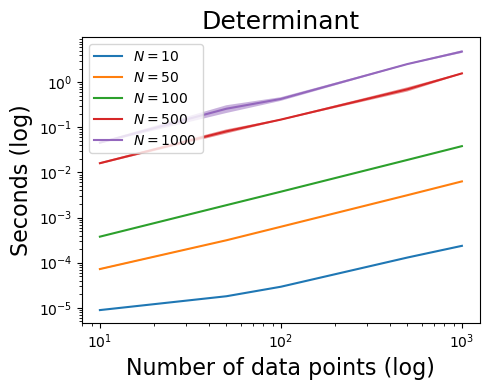

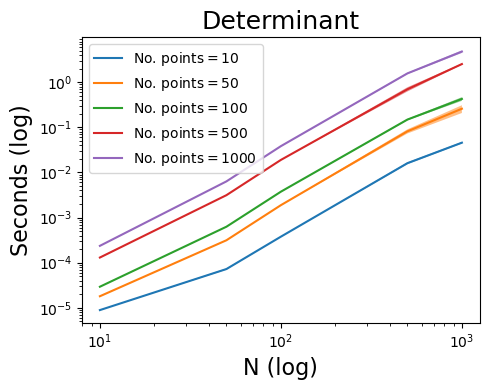

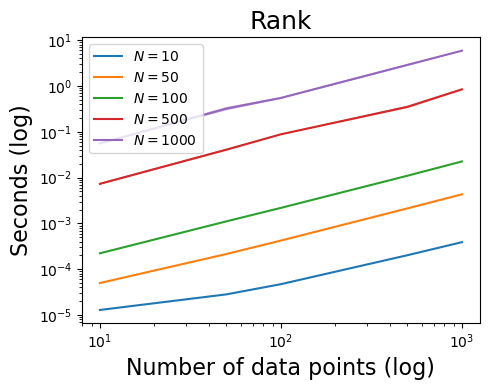

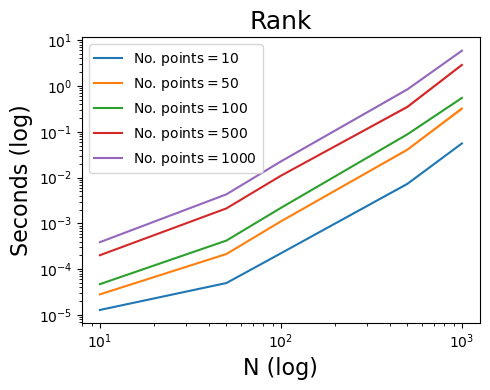

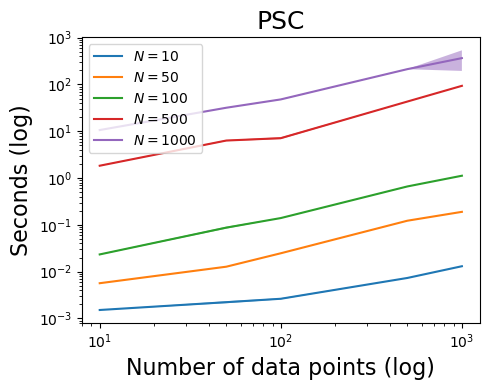

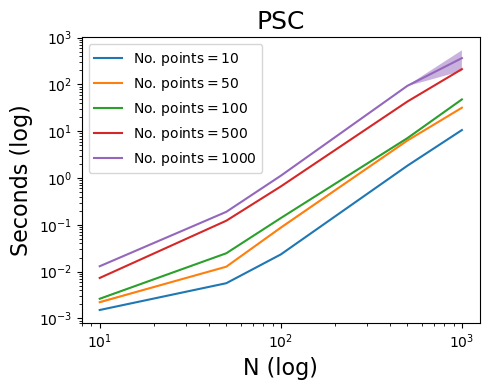

In [9]:
for label, t in zip(['Determinant', 'Rank', 'PSC'], [t1, t2, t3]):
    mean_t = t.mean(axis=-1)
    std_t = t.std(axis=-1)
    
    fig, ax = plt.subplots(1, figsize=(5,4))
    for j in range(len(N)):
        plt.plot(s, mean_t[:, j], label=f'$N={N[j]}$')
        plt.fill_between(s, mean_t[:, j]-std_t[:, j], mean_t[:, j]+std_t[:, j], alpha=0.5)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of data points (log)', fontsize=16)
    plt.ylabel('Seconds (log)', fontsize=16)
    plt.title(label, fontsize=18)
    plt.legend()
    plt.tight_layout()
    plt.savefig(label+'-s.pdf', dpi=300)
    plt.show()
    
    fig, ax = plt.subplots(1, figsize=(5,4))
    for i in range(len(s)):
        plt.plot(N, mean_t[i, :], label=f'No. points$={s[i]}$')
        plt.fill_between(N, mean_t[i, :]-std_t[i, :], mean_t[i, :]+std_t[i, :], alpha=0.5)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('N (log)', fontsize=16)
    plt.ylabel('Seconds (log)', fontsize=16)
    plt.title(label, fontsize=18)
    plt.legend()
    plt.tight_layout()
    plt.savefig(label+'-N.pdf', dpi=300)
    plt.show()

# Test RANSAC

In [10]:
s = 1000
N = 200
n = 50
k = 5

p_true = 0.98

ys_inliers = stiefel_point_cloud(N,n,k,int(p_true*s),0.01)['points']
ys_outliers = stiefel_point_cloud(N,n,k,s-int(p_true*s),0.01)['points']
ys = np.concatenate((ys_inliers,ys_outliers), axis=0)

print(ys.shape)

ys_new = ransac(ys, n, p = 0.99, tau = 3, verbose=True)
print(len(ys_new))

(1000, 200, 5)
20 [989 996 988 998 986 980 999 991 997 982 983 987 984 994 985 981 992 990
 995 993]
2 [443 133]
0 []
978


In [11]:
%timeit ransac(ys, n, p = 0.99, tau = 3, verbose=False)

914 ms ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
